In [1]:
import time 
from functools import partial
import numpy as onp
import jax.numpy as np
from jax import jit
from jax import grad
from jax import vmap
from jax import value_and_grad
from jax import random
from jax import lax
import matplotlib
import matplotlib.pyplot as plt
from jax.example_libraries.stax import Dense, serial, Relu
from jax.example_libraries import optimizers 
from jax.config import config

config.update('jax_enable_x64', True)

# NOTE(schsam): We need this in OSS I think.
from IPython.display import HTML, display
import time

def simulation(key, temperature):
  pos_key, sim_key = random.split(key)

  R = random.uniform(pos_key, (N, 2), maxval=box_size)

  init_fn, apply_fn = simulate.brownian(energy_fn, shift, dt, temperature)
  state = init_fn(sim_key, R)

  do_step = lambda state, t: (apply_fn(state, t=t), t)
  state, _ = lax.scan(do_step, state, simulation_steps)

  return state.position

def draw_system(R, box_size, marker_size, color=None):
  if color == None:
    color = [64 / 256] * 3
  ms = marker_size / box_size

  R = onp.array(R)

  marker_style = dict(
      linestyle='none', 
      markeredgewidth=3,
      marker='o', 
      markersize=ms, 
      color=color, 
      fillstyle='none')

  plt.plot(R[:, 0], R[:, 1], **marker_style)
  plt.plot(R[:, 0] + box_size, R[:, 1], **marker_style)
  plt.plot(R[:, 0], R[:, 1] + box_size, **marker_style)
  plt.plot(R[:, 0] + box_size, R[:, 1] + box_size, **marker_style)
  plt.plot(R[:, 0] - box_size, R[:, 1], **marker_style)
  plt.plot(R[:, 0], R[:, 1] - box_size, **marker_style)
  plt.plot(R[:, 0] - box_size, R[:, 1] - box_size, **marker_style)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.axis('off')

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def ProgressIter(iter_fun, iter_len=0):
  if not iter_len:
    iter_len = len(iter_fun)
  out = display(progress(0, iter_len), display_id=True)
  for i, it in enumerate(iter_fun):
    yield it
    out.update(progress(i + 1, iter_len))
    
def progress(value, max):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 45%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

def format_plot(x, y):  
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)


Below is the quenched system.


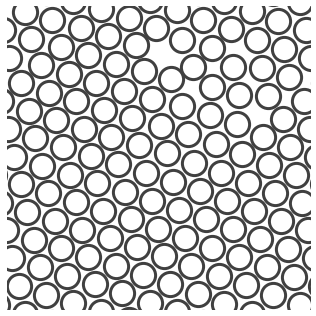

In [2]:
from jax_md import quantity
from jax_md import space, energy, simulate

N = 128
dt = 1e-2
simulation_steps = np.arange(4000)
key = random.PRNGKey(0)

box_size = quantity.box_size_at_number_density(particle_count=N,
                                               number_density=1.2,
                                               spatial_dimension=2)
displacement, shift = space.periodic(box_size)

energy_fn = energy.soft_sphere_pair(displacement)

bubble_positions = simulation(key, temperature=1e-5)

print('Below is the quenched system.')    
draw_system(bubble_positions, box_size, 250.0)
finalize_plot((0.75, 0.75))

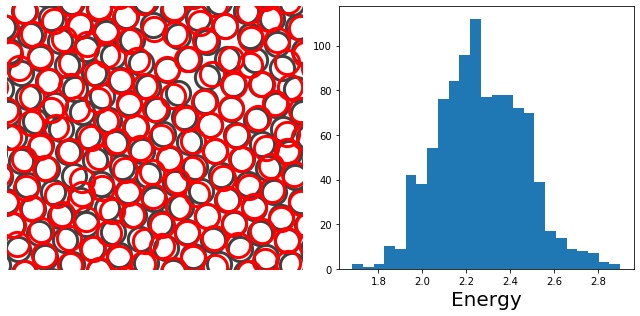

In [3]:
samples = 1000

key, distortion_key = random.split(key)
distortion = random.normal(distortion_key, (samples, N, 2)) * 0.1
distorted_positions = bubble_positions + distortion

energies = vmap(energy_fn)(distorted_positions)

plt.subplot(1, 2, 1)
draw_system(bubble_positions, box_size, 250.0)
draw_system(distorted_positions[0], box_size, 250.0, color=[1, 0, 0])

plt.subplot(1, 2, 2)
plt.hist(energies, bins=25)
plt.xlabel('Energy', fontsize=20)

finalize_plot((1.5, 0.75))

g(r) has shape (N, number of radii) = (128, 60).


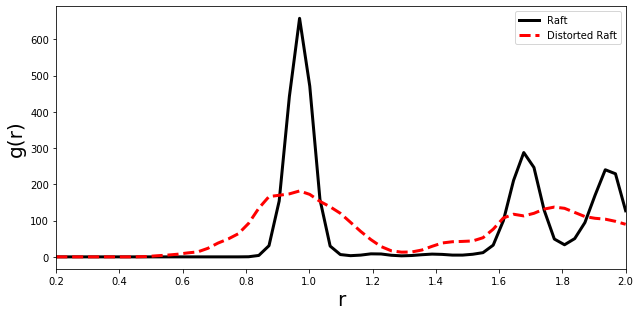

In [4]:
feature_rs = np.linspace(0.1, 2.0, 60)
g = quantity.pair_correlation(space.metric(displacement), feature_rs, 0.033)

pair_corr = g(bubble_positions)
print("g(r) has shape (N, number of radii) = {}.".format(pair_corr.shape))
plt.plot(feature_rs, np.sum(pair_corr, axis=0), 'k', linewidth=3)

plt.plot(
    feature_rs, np.sum(g(distorted_positions[0]), axis=0), 'r--', linewidth=3)

plt.xlabel('r', fontsize=20)
plt.ylabel('g(r)', fontsize=20)

plt.legend(['Raft', 'Distorted Raft'], loc='upper right')
plt.xlim([0.2, 2])

finalize_plot((1.5, 0.75))

In [5]:
no_training_samples = 800
print('Total number of examples is {}, number of\
 training examples is {}'.format(len(distorted_positions), no_training_samples))

vectorized_g = jit(vmap(g))

train_positions = np.array(distorted_positions[:no_training_samples])
train_features = vectorized_g(train_positions)
test_positions = np.array(distorted_positions[no_training_samples:])
test_features = vectorized_g(test_positions)

Total number of examples is 1000, number of training examples is 800


In [6]:
no_hidden_units = 30
init_fun, _E = serial(
    Dense(no_hidden_units, ), Relu,  # hidden layer 1
    Dense(no_hidden_units), Relu,  # hidden layer 2
    Dense(1))  # readout

E = lambda params, features: _E(params, features)

In [7]:
def loss(params, positions, features):
  E_per_atom_per_system = E(params, features)
  E_total = np.sum(E_per_atom_per_system, axis=(1, 2))
  return np.mean((E_total - vmap(energy_fn)(positions))**2)
grad_loss = grad(loss)

In [8]:
key = random.PRNGKey(4)
train_steps = 3001
print_every = 250
batch_size = 50

training_samples = np.arange(no_training_samples)

# Initialize the network.
key, net_key = random.split(key)
_, params = init_fun(net_key, (-1, N, len(feature_rs)))
# np.savetxt('params.out', params, delimiter=',') 
# import json
# with open('params.json', 'w') as f:
#     json.dump(params, f)
# Create the optimizer.
opt_init, opt_update, get_params = optimizers.adam(1e-2)
state = opt_init(params)
# print(trained_params)


# Define and jit a single update step.
@jit
def update_step(state, batch):
  positions, features = batch
  params = get_params(state)
  d_params = grad_loss(params, positions, features)
  return opt_update(0, d_params, state)


def batch(key):
  steps_per_epoch = no_training_samples // batch_size 
  train_epochs = train_steps // steps_per_epoch
  for s in range(train_epochs):
    key, split = random.split(key)
    permutation = random.shuffle(split, training_samples)
    positions = train_positions[permutation]
    features = train_features[permutation]
    for i in range(0, no_training_samples, batch_size):
      batch_data = (positions[permutation[i:i + batch_size]], 
                    features[permutation[i:i + batch_size]])
      yield batch_data
  
# Precompute the test time energies.
test_energies = vmap(energy_fn)(test_positions)

print('Mean predictor loss on the test set is {:5.4f}'.format
      (np.mean((test_energies - np.mean(test_energies))**2)))

# Do the training.
t = time.time()
train_losses = []
test_losses = []

for i, b in ProgressIter(enumerate(batch(key)), train_steps):
  state = update_step(state, b)

  # Print some diagnostics.
  if i and i % print_every == 0:
    dt = time.time() - t
    train_loss = loss(get_params(state), train_positions, train_features)
    train_losses += [train_loss]
    
    test_loss = loss(get_params(state), test_positions, test_features)
    test_losses += [test_loss]

    print(('Time: {:5.2f}\tStep: {:4d}\t'
           'Training-loss: {:5.4f}\tTest-loss: {:5.4f}').format(
        dt, i, train_loss, test_loss))
    t = time.time()

import json
def dump2json(params, file_name):
    out_dict = {}
    for i, layer in enumerate(params):
        layer_dict = {}
        if len(layer) != 0:
            layer_dict['Weight'] = layer[0].tolist()
            layer_dict['Bias'] = layer[1].tolist()
        out_dict[f'Layer {i}'] = layer_dict
    with open(file_name, 'w') as f:
        json.dump(out_dict, f)
# dump2json(params, "params.json")

Mean predictor loss on the test set is 0.0318


/home1/ibayashi/anaconda3/lib/python3.7/site-packages/jax/_src/random.py:368: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


Time:  3.81	Step:  250	Training-loss: 0.1090	Test-loss: 0.1001
Time:  1.53	Step:  500	Training-loss: 0.0809	Test-loss: 0.0744
Time:  1.53	Step:  750	Training-loss: 0.0647	Test-loss: 0.0588
Time:  1.54	Step: 1000	Training-loss: 0.0540	Test-loss: 0.0491
Time:  1.54	Step: 1250	Training-loss: 0.0473	Test-loss: 0.0438
Time:  1.54	Step: 1500	Training-loss: 0.0423	Test-loss: 0.0396
Time:  1.54	Step: 1750	Training-loss: 0.0383	Test-loss: 0.0368
Time:  1.54	Step: 2000	Training-loss: 0.0350	Test-loss: 0.0347
Time:  1.54	Step: 2250	Training-loss: 0.0319	Test-loss: 0.0322
Time:  1.54	Step: 2500	Training-loss: 0.0304	Test-loss: 0.0311
Time:  1.54	Step: 2750	Training-loss: 0.0275	Test-loss: 0.0289


In [9]:
params = get_params(state)
neural_energy_fn = lambda r: np.sum(E(params, g(r)), axis=(0, 1))

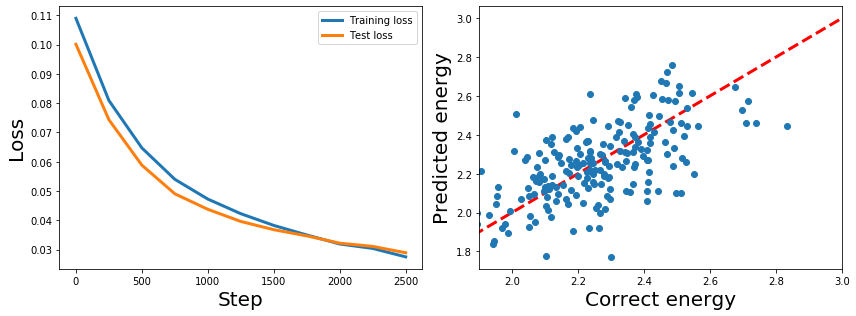

In [10]:
plt.subplot(1, 2, 1)

out_steps = [x * print_every for x in range(len(train_losses))]
plt.plot(out_steps, train_losses, linewidth=3, label='Training loss')
plt.plot(out_steps, test_losses, linewidth=3, label='Test loss')
plt.legend(loc='upper right')
format_plot('Step', 'Loss')

plt.subplot(1, 2, 2)


plt.plot(np.arange(1.8, 3.1, 0.1), np.arange(1.8, 3.1, 0.1), 'r--', linewidth=3)
plt.plot(test_energies, vmap(neural_energy_fn)(test_positions), 'o')
plt.xlabel('Correct energy', fontsize=20)
plt.ylabel('Predicted energy', fontsize=20)

plt.xlim([1.9, 3.0])

finalize_plot((2, 0.75))
